# Testing code for my 2.5D forward simulation and inversion using simpeg

In this file I define all the functions explicitly, which in the `.py` files I import from `functions.py` instead.

In [1]:
# imports

# SimPEG functionality
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.utils import model_builder
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)
from simpeg.electromagnetics.static.utils.static_utils import (
    generate_survey_from_abmn_locations,
    pseudo_locations,
    plot_pseudosection,
    apparent_resistivity_from_voltage,
)

# Suppress the DefaultSolverWarning
import warnings
import simpeg.utils.solver_utils  # Ensure the module is imported

warnings.filterwarnings(
    "ignore", category=simpeg.utils.solver_utils.DefaultSolverWarning
)

# discretize functionality
from discretize import TreeMesh
from discretize.utils import active_from_xyz


# Common Python functionality
import numpy as np
from scipy.spatial import cKDTree
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

mpl.rcParams.update({"font.size": 14})  # default font size
cmap = mpl.cm.RdYlBu_r  # default colormap

## Read in the survey layout from the res2dinv file, generate the survey and save the electrode positions as the topography

In [2]:
# read in the electrode locations from the res2dinv data file

file_path = "data/Project4_Wenner_1.dat"

with open(file_path, "r") as file:
    lines = file.readlines()

num_data_points = int(lines[6].strip())  # Number of data points

# Read the data section
A = np.zeros((num_data_points, 2))
B = np.zeros((num_data_points, 2))
M = np.zeros((num_data_points, 2))
N = np.zeros((num_data_points, 2))
dobs = np.zeros(num_data_points)
error = np.zeros(num_data_points)

data_start_line = 12
for i, line in enumerate(lines[data_start_line : data_start_line + num_data_points]):
    values = line.strip().split()
    if len(values) >= 11:
        A[i] = [float(values[1]), float(values[2])]
        B[i] = [float(values[3]), float(values[4])]
        M[i] = [float(values[5]), float(values[6])]
        N[i] = [float(values[7]), float(values[8])]
        dobs[i] = float(values[9])  # Voltage
        error[i] = float(values[10])  # Error percentage

In [3]:
# Generate the survey
survey = generate_survey_from_abmn_locations(
    locations_a=A, locations_b=B, locations_m=M, locations_n=N, data_type="volt"
)

In [4]:
# Topo from electrode positions (flat)
topo_2d = np.unique(np.vstack([A, B, M, N]), axis=0)

### Plot the electrode locations and resulting pseudolocations

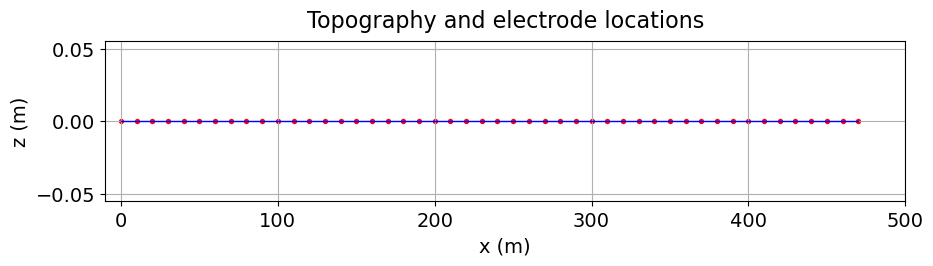

In [5]:
# plot topography with electrode positions
fig = plt.figure(figsize=(10, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(topo_2d[:, 0], topo_2d[:, 1], color="b", linewidth=1)
ax.scatter(topo_2d[:, 0], topo_2d[:, 1], 8, "r")
ax.set_xlim([-10, 500])
ax.set_xlabel("x (m)", labelpad=5)
ax.set_ylabel("z (m)", labelpad=5)
ax.grid(True)
ax.set_title("Topography and electrode locations", fontsize=16, pad=10)
plt.show(fig)

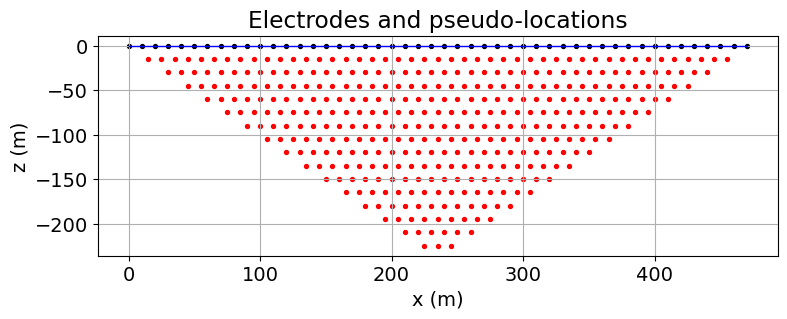

In [6]:
# plot pseudo-locations
pseudo_locations_xz = pseudo_locations(survey)
fig = plt.figure(figsize=(8, 2.75))
ax = fig.add_axes([0.1, 0.1, 0.85, 0.8])
ax.scatter(pseudo_locations_xz[:, 0], pseudo_locations_xz[:, -1], 8, "r")
ax.plot(topo_2d[:, 0], topo_2d[:, 1], color="b", linewidth=1)
ax.scatter(topo_2d[:, 0], topo_2d[:, 1], 8, "k")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.set_title("Electrodes and pseudo-locations")
ax.grid(True)
plt.show()

## Build and plot my tree mesh 

In [7]:
# dh = 5  # minimum cell width
# dom_width_x = np.max(topo_2d[:, 0]) - np.min(topo_2d[:, 0])  # domain width x
# dom_width_z = np.max(topo_2d[:, 1]) - (np.min(topo_2d[:, 1] - 250))  # domain width z
# dz = 5
# nbcx = 2 ** (
#     int(np.round(np.log(dom_width_x / dh) / np.log(2.0))) + 1
# )  # num. base cells x
# nbcz = 2 ** (int(np.ceil(np.log(dom_width_z / dz) / np.log(2.0))))  # num. base cells z


# # Define the base mesh with top at z = 0 m.
# hx = [(dh, nbcx)]
# hz = [(dz, nbcz)]
# mesh = TreeMesh([hx, hz], x0="0N", diagonal_balance=True)

# # Shift top to maximum topography
# mesh.origin = mesh.origin + np.r_[-200, np.max(topo_2d[:, 1])]

# # Mesh refinement based on topography
# mesh.refine_surface(
#     topo_2d,
#     padding_cells_by_level=[10, 10, 5, 5],
#     finalize=False,
# )

# # Extract unique electrode locations.
# unique_locations = survey.unique_electrode_locations

# # Mesh refinement near electrodes.
# # mesh.refine_points(
# #     unique_locations, padding_cells_by_level=[1, 1, 1, 1], finalize=False
# # )

# mesh.finalize()

In [8]:
# print("# of cells: {}".format(mesh.n_cells))  # Number of cells
# print("# of x-faces: {}".format(mesh.n_faces_x))  # Number of x-faces
# print("Origin: {}".format(mesh.origin))  # bottom-southewest corner
# print("Max cell volume: {}".format(mesh.cell_volumes.max()))  # Largest cell size
# print(mesh.cell_centers[0:5, :])  # Cell center locations

In [9]:
# fig = plt.figure(figsize=(10, 4))

# ax1 = fig.add_axes([0.14, 0.17, 0.8, 0.7])
# mesh.plot_grid(ax=ax1, linewidth=1)
# ax1.grid(False)
# ax1.set_xlim(np.min(topo_2d[:, 0]), np.max(topo_2d[:, 0]))
# ax1.set_ylim(np.min(topo_2d[:, 1]) - 300, np.max(topo_2d[:, 1]))
# ax1.set_title("Mesh")
# ax1.set_xlabel("x (m)")
# ax1.set_ylabel("z (m)")

# plt.show()

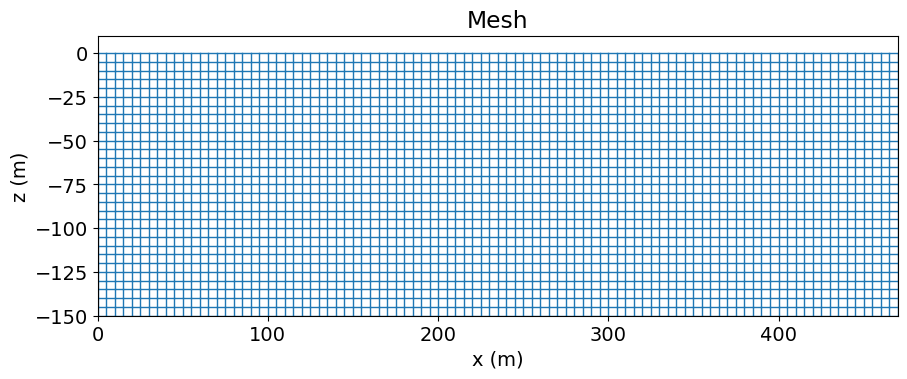

In [11]:
from utils import build_tensor_mesh

dx = 5
width = 470
depth = 150
mesh, active_cells = build_tensor_mesh(topo_2d, dx=dx, dz=dx, width=width, depth=depth)

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_axes([0.14, 0.17, 0.8, 0.7])
mesh.plot_grid(ax=ax1, linewidth=1)
ax1.grid(False)
ax1.set_xlim(0, width)
ax1.set_ylim(-depth, np.max(topo_2d[:, 1]) + 10)
ax1.set_title("Mesh")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

plt.show()

## Define the active cells (not air) and then build my synthetic resistivity model

In [12]:
# number of active cells
n_active = np.sum(active_cells)

In [ ]:
# set resisitivity values
air_resistivity = 1e8
permafrost_resistivity = 600
bedrock_resistivity = 10000
ice_resistivity = 1000
unfrozen_resistivity = 400

In [14]:
# # Define a resistivity model
# resistivity_model = bedrock_resistivity * np.ones(n_active)

resistivity_model = model_builder.create_2_layer_model(
    mesh.cell_centers, 50, permafrost_resistivity, bedrock_resistivity
)

# # add blocks
# ind_perma = model_builder.get_indices_block(
#     np.r_[-1000, -80], np.r_[5000, 0], mesh.cell_centers[active_cells, :]
# )

# resistivity_model[ind_perma] = permafrost_resistivity

# ind_ice = model_builder.get_indices_block(
#     np.r_[80, -60], np.r_[250, -30], mesh.cell_centers[active_cells, :]
# )
# resistivity_model[ind_ice] = ice_resistivity

# ind_ice_wedge = model_builder.get_indices_block(
#     np.r_[350, -80], np.r_[360, -10], mesh.cell_centers[active_cells, :]
# )
# resistivity_model[ind_ice_wedge] = ice_resistivity

# Define log-resistivity model - need to invert in log space to avoid non-physical negative values
log_resistivity_model = np.log(resistivity_model)

## Map the resistivity model to the mesh cell locations

In [15]:
# Conductivity map. Model parameters are conductivities for all active cells.
log_resistivity_map = maps.InjectActiveCells(
    mesh, active_cells, np.log(air_resistivity)
) * maps.ExpMap(nP=n_active)

In [16]:
# Generate a mapping to ignore inactice cells in plot
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

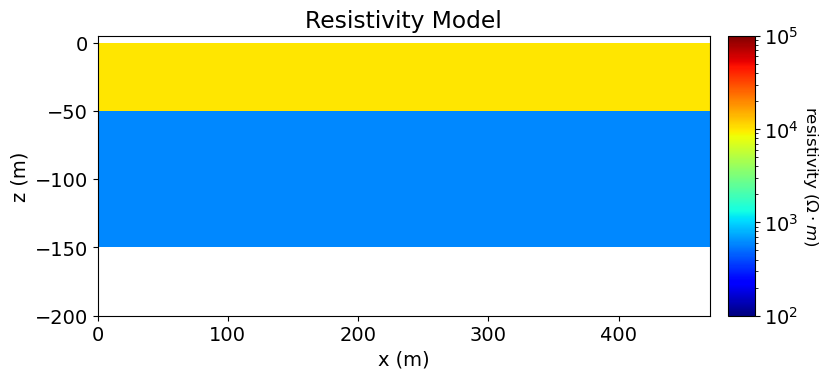

In [17]:
fig = plt.figure(figsize=(9, 4))

norm = LogNorm(vmin=1e2, vmax=1e5)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * resistivity_model,
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.jet},
)
ax1.set_xlim(np.min(topo_2d[:, 0]), np.max(topo_2d[:, 0]))
ax1.set_ylim(np.max(topo_2d[:, 1]) - 200, np.max(topo_2d[:, 1] + 5))
ax1.set_title("Resistivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.jet
)
cbar.set_label(r"resistivity ($\Omega \cdot m$)", rotation=270, labelpad=15, size=12)

plt.show()

### Ensure the electrodes are at the surface (not above or below)

In [18]:
survey.drape_electrodes_on_topography(mesh, active_cells, option="top")

## Define the forwards simulation, and get the predicted data, then plot in a pseudosection

In [19]:
# DC simulation for a log resistivity model
simulation = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=survey, rhoMap=log_resistivity_map, storeJ=True
)

dpred = simulation.dpred(log_resistivity_model)

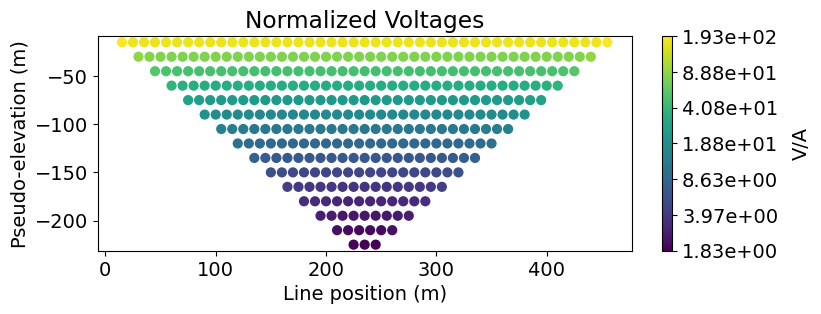

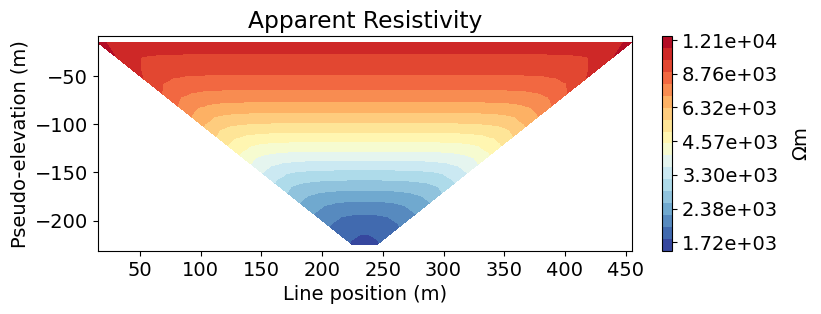

In [20]:
# Plot voltages pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    survey,
    dobs=np.abs(dpred),
    plot_type="scatter",
    ax=ax1,
    scale="log",
    cbar_label="V/A",
    scatter_opts={"cmap": mpl.cm.viridis},
)
ax1.set_title("Normalized Voltages")
plt.show()

# Get apparent conductivities from volts and survey geometry
apparent_resistivities = apparent_resistivity_from_voltage(survey, dpred)

# Plot apparent conductivity pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    survey,
    dobs=apparent_resistivities,
    plot_type="contourf",
    ax=ax1,
    scale="log",
    cbar_label="$\Omega$m",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_title("Apparent Resistivity")
plt.show()

## Add 5% random noise to the simulated data, then save this as a data object to be used in the following inversion

In [21]:
# Add 5% Gaussian noise to each datum
rng = np.random.default_rng(seed=225)
std = 0.05 * np.abs(dpred)
dc_noise = rng.normal(scale=std, size=len(dpred))
dobs = dpred + dc_noise

data_dc = data.Data(survey, dobs=dobs, standard_deviation=std)

# 2.5D Least-squares inversion

In [24]:
# dobs = dpred_con
# standard_deviation = 0.05 * np.abs(dobs)
# simulation_res

### Define a starting model as the bedrock resistivity

In [22]:
# Define conductivity model in S/m (or resistivity model in Ohm m)
background_resistivity = bedrock_resistivity  # ENDS UP SMOOTHER + FASTER...
background_resistivity = np.mean(apparent_resistivities)  # bedrock_resistivity

# active_map = maps.InjectActiveCells(mesh, ind_active, np.exp(air_conductivity))
nC = int(active_cells.sum())

# Define model
starting_log_resistivity_model = np.log(background_resistivity) * np.ones(nC)

# Define the data misfit. 
Here the data misfit is the L2 norm of the weighted residual between the observed data and the data predicted for a given model.

Within the data misfit, the residual between predicted and observed data are normalized by the data's standard deviation.

In [24]:
# TEST 1 - all at most basic version
dmis = data_misfit.L2DataMisfit(data=data_dc, simulation=simulation)

# Define the regularization (model objective function)
# least-squares regularization
reg = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_cells,
    mapping=log_resistivity_map,
    # alpha_s=1e-6,
    # alpha_x=1,
    # alpha_y=1,
    reference_model=starting_log_resistivity_model,  # no reference model?...
    reference_model_in_smooth=True,  # no reference model?...
)

### Optimization and setting up the inverse problem

Optimization lets us set the max number of iterations using these inputs:

### 🔁 maxIter
This sets the maximum number of Gauss-Newton iterations (i.e., the number of major steps the optimizer will take to update the model).
Each of these iterations involves solving a linear system that approximates the inverse problem.

### 🔍 maxIterLS
This is the maximum number of line search steps within a single Gauss-Newton iteration.
The line search controls how far along the proposed update direction the algorithm will move to ensure a reduction in the objective function
Helps prevent overshooting or making unstable updates.

### 🔄 maxIterCG
This sets the maximum number of Conjugate Gradient (CG) iterations for solving the linear system inside each Gauss-Newton iteration.
Since directly solving the system is computationally expensive, the CG method solves it approximately.
A higher value gives a more accurate solution but is more computationally expensive.

### 🎯 tolCG
This is the tolerance for the CG solver.
The CG iterations stop once the residual of the linear system is below this threshold.
A smaller tolerance means a more accurate inner solution, but more CG iterations may be needed.

In [25]:
# Define how the optimization problem is solved. Here we will use an
maxIter = 40
maxIterLS = 50
maxIterCG = 20
tolCG = 1e-3

# Inexact Gauss Newton approach.
opt = optimization.InexactGaussNewton(
    maxIter=maxIter, maxIterLS=maxIterLS, maxIterCG=maxIterCG, tolCG=tolCG
)


# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

## Inversion Directives

### UpdateSensitivityWeights
Re-weights the regularization based on sensitivity at each iteration.
Helps suppress overfitting low-sensitivity areas — this is generally a good idea, especially for resistivity.

### UpdatePreconditioner
Recomputes the preconditioner each iteration.
Improves solver performance, no downside here.

### BetaEstimate_ByEig(beta0_ratio=10)
Uses eigenvalue estimation to set the initial beta.
beta0_ratio=10 means your starting regularization weight is 10× the optimal value (based on data and model Hessians).
This can start too smooth and stay smooth if not cooled aggressively — something to watch.

### BetaSchedule(coolingFactor=2, coolingRate=2)
Reduces beta over iterations to allow more data fit.
With a cooling factor of 2, beta is halved.
But coolingRate=2 means it does that every 2 iterations — so it might not be aggressive enough if smoothing is staying high.

### TargetMisfit(chifact=2.0)
Stops the inversion once the data misfit reaches ~2× the noise level.
This is fine, but if you're still smoothing too much before hitting this, your regularization is dominating.

In [28]:
# Apply and update sensitivity weighting as the model updates
update_sensitivity_weighting = directives.UpdateSensitivityWeights()

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=3, coolingRate=2)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# Update preconditioner
update_jacobi = directives.UpdatePreconditioner()

directives_list = [
    update_sensitivity_weighting,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
    update_jacobi,
]

## Carry out inversion and plot

In [29]:
# Here we combine the inverse problem and the set of directives
dc_inversion = inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run inversion
recovered_resistivity_model = dc_inversion.run(starting_log_resistivity_model)


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        


/Users/cara/opt/miniconda3/envs/eosc-556-project/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.33e+00  1.52e+05  7.06e+04  3.87e+05    2.40e+04      0              
   1  3.33e+00  2.71e+04  1.80e+04  8.69e+04    2.60e+03      0              
   2  1.11e+00  2.89e+04  1.02e+04  4.02e+04    1.19e+03      0   Skip BFGS  
   3  1.11e+00  6.03e+03  2.45e+04  3.32e+04    6.93e+02      0              
   4  3.70e-01  9.21e+03  2.08e+04  1.69e+04    9.86e+02      0              
   5  3.70e-01  1.64e+03  3.29e+04  1.38e+04    2.62e+02      0              
   6  1.23e-01  2.18e+03  3.11e+04  6.02e+03    5.31e+02      0              
   7  1.23e-01  6.87e+02  3.82e+04  5.40e+03    1.92e+02      0              
   8  4.11e-02  6.54e+02  3.82e+04  2.22e+03    2.82e+02      7              
   9  4.11e-02  5.92e+02

In [30]:
recovered_resistivity_model

array([6.20069099, 6.0008541 , 5.94381964, ..., 9.12214579, 9.04670424,
       9.30970696], shape=(2820,))

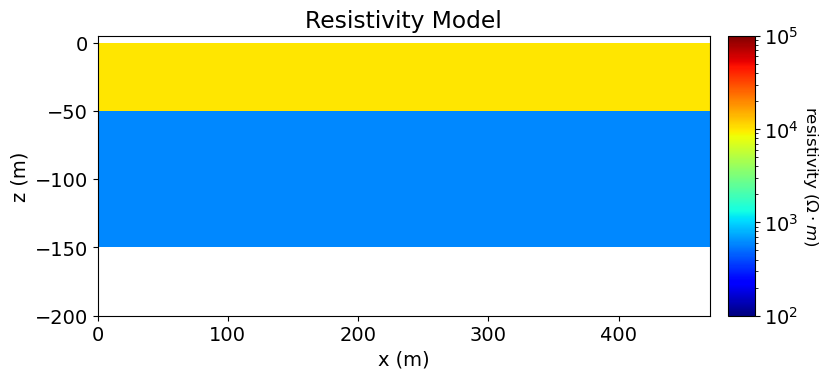

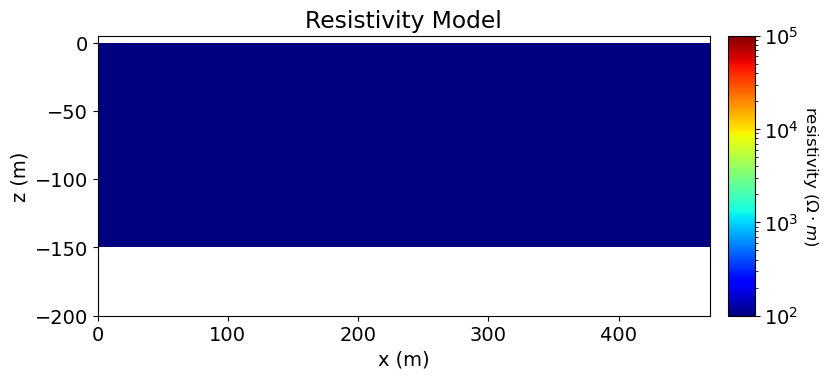

In [31]:
fig = plt.figure(figsize=(9, 4))

norm = LogNorm(vmin=1e2, vmax=1e5)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * resistivity_model,
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.jet},
)
ax1.set_xlim(np.min(topo_2d[:, 0]), np.max(topo_2d[:, 0]))
ax1.set_ylim(np.max(topo_2d[:, 1]) - 200, np.max(topo_2d[:, 1] + 5))
ax1.set_title("Resistivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.jet
)
cbar.set_label(r"resistivity ($\Omega \cdot m$)", rotation=270, labelpad=15, size=12)

plt.show()

fig = plt.figure(figsize=(9, 4))

norm = LogNorm(vmin=1e2, vmax=1e5)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * recovered_resistivity_model,
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.jet},
)
ax1.set_xlim(np.min(topo_2d[:, 0]), np.max(topo_2d[:, 0]))
ax1.set_ylim(np.max(topo_2d[:, 1]) - 200, np.max(topo_2d[:, 1] + 5))
ax1.set_title("Resistivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.jet
)
cbar.set_label(r"resistivity ($\Omega \cdot m$)", rotation=270, labelpad=15, size=12)

plt.show()

In [32]:
recovered_resistivity_model_2d = recovered_resistivity_model.reshape(
    mesh.shape_cells, order="F"
)

drop_threshold = 100

x_locs = mesh.cell_centers_x
z_locs = mesh.cell_centers_y

nz = mesh.shape_cells[1]
interface_depths = np.full_like(x_locs, np.nan, dtype=float)

# Ensure z goes from shallow (top) to deep (bottom)
sort_z = np.argsort(z_locs)
z_sorted = z_locs[sort_z]

for i, x in enumerate(x_locs):
    res_col = recovered_resistivity_model_2d[i, :]  # grab column (bottom to top?)
    res_col_sorted = res_col[sort_z]

    dz = np.diff(z_sorted)
    dres = np.diff(res_col_sorted)
    grad = dres / dz

    drop_inds = np.where(grad < -drop_threshold)[0]
    if drop_inds.size > 0:
        idx = drop_inds[0]
        interface_depths[i] = (z_sorted[idx] + z_sorted[idx + 1]) / 2

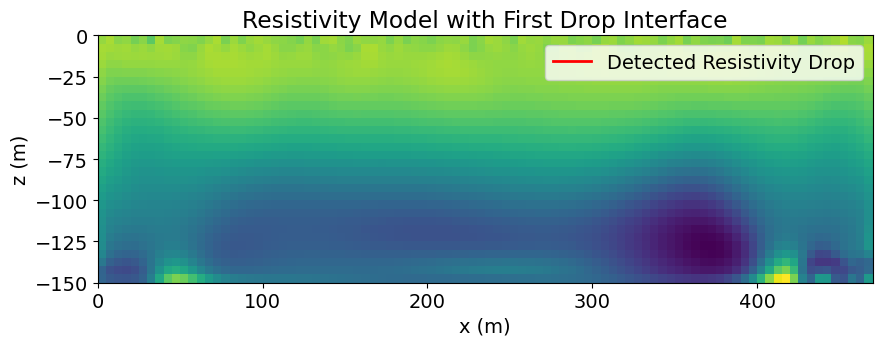

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
mesh.plot_image(
    recovered_resistivity_model_2d,
    ax=ax,
    grid=False,
    pcolor_opts={"cmap": "viridis", "norm": "log"},
)
ax.plot(x_locs, interface_depths, "r-", lw=2, label="Detected Resistivity Drop")
ax.set_title("Resistivity Model with First Drop Interface")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.legend()
plt.gca().set_aspect("equal")
plt.show()